[Info] Filled 0 NaN cells in rho grid.
[Info] Filled 0 NaN cells in S grid.
[Success] Built RegularGridInterpolators on 99×99 grid.
ρ grid shape: (99, 99), S grid shape: (99, 99)
Rho grid shape: (99, 99)
S grid shape: (99, 99)
Rho NaN count: 0
Rho = 27.61305631052566 g/cc
S = 0.21003995127485423 kB/Baryon


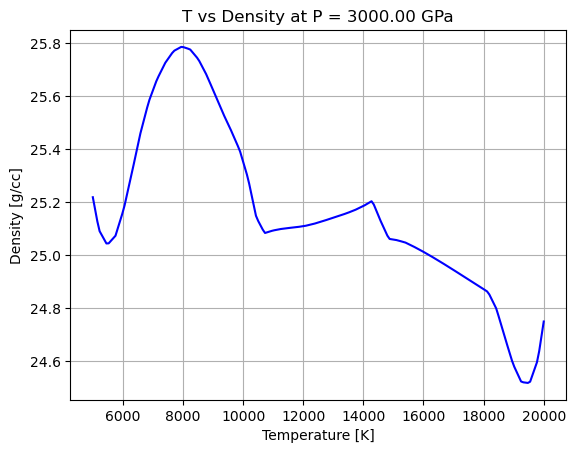

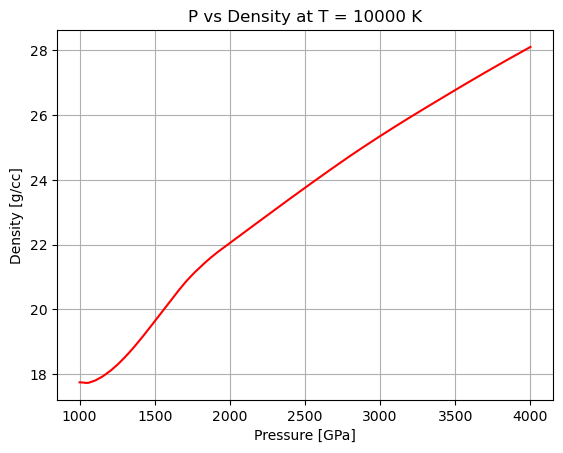

0.012928750988316584
0.19986846158502547


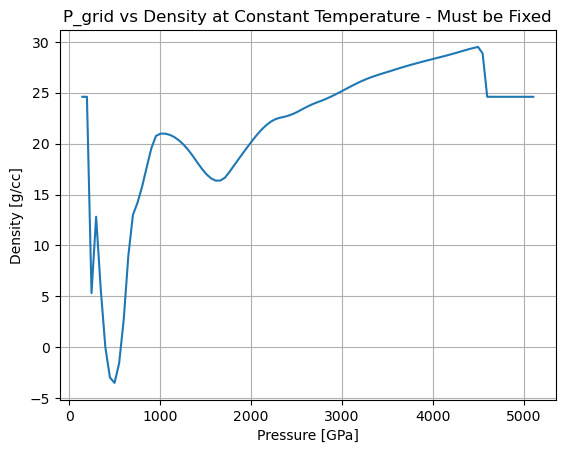

In [15]:
import os
import re
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.interpolate import RegularGridInterpolator
from astropy.constants import k_B
from astropy.constants import u as amu
from scipy.optimize import brentq, brenth
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict

#### Setting Project Root for File Calls across platforms ####
IRON_EOSS = r"C:\Users\usame\eos\gonzales_iron_eos"  #Add either 'liquid_eos.dat' or 'solid_eos.dat' as a *part

def iron_project_path(*parts):
    return os.path.join(IRON_EOSS, *parts)

# Conversion constants
HA_TO_ERG = 4.3597447e-11
BARYONS_PER_FE = 56

#-------------------------------------- File Reading & Array Creation (including conversions) -----------------------------------------

def parse_eos_table(filename):
    pressures, temps, rhos, entropies, energies = [], [], [], [], []

    with open(filename, "r") as f:
        for line in f:
            if line.strip() == "" or line.startswith("#"):
                continue

            # Extract numerical values with regex
            rho_match = re.search(r"rho\[g/cc\]=\s*([0-9\.E\+\-]+)", line)
            T_match   = re.search(r"T\[K\]=\s*([0-9\.E\+\-]+)", line)
            P_match   = re.search(r"P\[GPa\]=\s*([0-9\.E\+\-]+)", line)
            S_match   = re.search(r"S\[kB/atom\]=\s*([0-9\.E\+\-]+)", line)
            E_match   = re.search(r"E\[Ha/Fe\]=\s*([0-9\.E\+\-]+)", line)

            # Only add if all fields were successfully matched
            if all([rho_match, T_match, P_match, S_match, E_match]):
                rhos.append(float(rho_match.group(1)))
                temps.append(float(T_match.group(1)))
                pressures.append(float(P_match.group(1)))
                entropies.append(float(S_match.group(1)))
                energies.append(float(E_match.group(1)))

    # Convert to NumPy arrays
    pressures = np.array(pressures)
    temps     = np.array(temps)
    rhos      = np.array(rhos)
    entropies = np.array(entropies)
    energies  = np.array(energies)

    #UNIT CONVERSIONS
    BARYONS_PER_FE = 56
    entropies /= BARYONS_PER_FE

    return pressures, temps, rhos, entropies, energies

#-------------------------------------- Interpolator Function Creation (to be separated into smaller components) ------------------------

def build_RGI_interpolator(pressures, temps, rhos, entropies, nP=99, nT=99, fill_value=None): 
    """
    Build RegularGridInterpolators for rho(P,T) and S(P,T),
    automatically resampling the scattered EoS data onto
    a uniform (nP x nT) rectangular grid.

    Parameters
    ----------
    pressures, temps : 1D arrays
        Raw EoS pressure [GPa] and temperature [K] data.
    rhos, entropies : 1D arrays
        Corresponding density [g/cc] and entropy [kB/atom] data.
    nP, nT : int
        Desired grid resolution in pressure and temperature.
    fill_value : float or None
        Value to use for extrapolation (default None → extrapolate).

    Returns
    -------
    rho_interp, s_interp : RegularGridInterpolator objects
        Interpolators for rho(P,T) and S(P,T).
    P_grid, T_grid : 1D arrays
        Uniform pressure and temperature grids used for interpolation.
    rho_grid, S_grid : 2D arrays
        Rectangular 2D data arrays used to build the interpolators.
    """

    #Define uniform grid ranges based on data
    P_min, P_max = np.min(pressures), np.max(pressures)
    T_min, T_max = np.min(temps), np.max(temps)
    P_grid = np.linspace(P_min, P_max, nP)
    T_grid = np.linspace(T_min, T_max, nT)
    PP, TT = np.meshgrid(P_grid, T_grid, indexing='ij')

    #Build smooth scattered interpolators for rho and S - after reading, try doing this with interp 1D (Make sure to visually inspect the interpolator results); then, create 2D meshes & pass to RGI
    rho_scattered = CloughTocher2DInterpolator(
        np.column_stack([pressures, temps]), rhos
    )
    S_scattered = CloughTocher2DInterpolator(
        np.column_stack([pressures, temps]), entropies
    )

    #Evaluate these on the regular grid
    rho_grid = rho_scattered(PP, TT)
    S_grid = S_scattered(PP, TT)

    #Fill any NaNs (at edges or sparse regions)
    if np.isnan(rho_grid).any():
        mean_rho = np.nanmean(rho_grid)
        rho_grid = np.where(np.isnan(rho_grid), mean_rho, rho_grid)
        print(f"[Info] Filled {np.isnan(rho_grid).sum()} NaN cells in rho grid.")

    if np.isnan(S_grid).any():
        mean_S = np.nanmean(S_grid)
        S_grid = np.where(np.isnan(S_grid), mean_S, S_grid)
        print(f"[Info] Filled {np.isnan(S_grid).sum()} NaN cells in S grid.")

    #Build RegularGridInterpolators
    rho_interp = RegularGridInterpolator(
        (P_grid, T_grid), rho_grid, bounds_error=False, fill_value=fill_value
    )
    s_interp = RegularGridInterpolator(
        (P_grid, T_grid), S_grid, bounds_error=False, fill_value=fill_value
    )

    print(f"[Success] Built RegularGridInterpolators on {nP}×{nT} grid.")
    print(f"ρ grid shape: {rho_grid.shape}, S grid shape: {S_grid.shape}")

    return rho_interp, s_interp, P_grid, T_grid, rho_grid, S_grid

#-------------------------------------- Graphing Functions (Density & Entropy) -----------------------------------------

def plot_solidEoS_temperature(rho_interp, P_fixed, T_min, T_max, npts=100):
    """
    Plot temperature vs density at constant pressure.
    """
    T_vals = np.linspace(T_min, T_max, npts)
    rho_vals = [rho_interp((P_fixed, T)) for T in T_vals]

    plt.figure()
    plt.plot(T_vals, rho_vals, 'b-')
    plt.xlabel("Temperature [K]")
    plt.ylabel("Density [g/cc]")
    plt.title(f"T vs Density at P = {P_fixed:.2f} GPa")
    plt.grid(True)
    plt.show()


def plot_solidEoS_pressure(rho_interp, T_fixed, P_min, P_max, npts=100):
    """
    Plot pressure vs density at constant temperature.
    """
    P_vals = np.linspace(P_min, P_max, npts)
    rho_vals = [rho_interp((P, T_fixed)) for P in P_vals]

    plt.figure()
    plt.plot(P_vals, rho_vals, 'r-')
    plt.xlabel("Pressure [GPa]")
    plt.ylabel("Density [g/cc]")
    plt.title(f"P vs Density at T = {T_fixed:.0f} K")
    plt.grid(True)
    plt.show()

def plot_solidEoS_temperature_PS(s_target, P_min, P_max, nP, s_interp, T_min=0, T_max=40000):
    """
    Plot temperature vs. pressure at constant entropy (NOTE: this is also called an "isentropic curve." This function is vital when attempting to evaluate a region's Ledoux criterion).
    """

    P_vals = np.linspace(P_min, P_max, nP)
    T_vals = []

    for P in P_vals:
        # Define entropy residual function at fixed P
        def f(T):
            return s_interp(P, T) - s_target

        try:
            # Check if S(P, T_min) and S(P, T_max) bracket s_target
            s_lo, s_hi = s_interp(P, T_min), s_interp(P, T_max)
            if np.isnan(s_lo) or np.isnan(s_hi):
                T_vals.append(np.nan)
                continue

            if (s_lo - s_target) * (s_hi - s_target) > 0:
                # target entropy not bracketed
                T_vals.append(np.nan)
                continue

            # Solve for T(P)
            T_sol = brentq(f, T_min, T_max)
            T_vals.append(T_sol)
        except Exception:
            T_vals.append(np.nan)
            print("This value is NaN")

    P_vals = np.array(P_vals)
    T_vals = np.array(T_vals)

    # Plot
   # plt.figure(figsize=(7,5))
   # plt.plot(P_vals, T_vals, 'b-', linewidth=2)
    #plt.xlabel("Pressure [GPa]", fontsize=12)
    #plt.ylabel("Temperature [K]", fontsize=12)
    #plt.title(f"Isentrope: S = {s_target:.3f} kB/baryon", fontsize=13)
    #plt.grid(True, linestyle='--', alpha=0.6)
    #plt.tight_layout()
    #plt.show()

    return P_vals, T_vals

#-------------------------------------- Updated Inversion Functions (S, P and S, Rho) -----------------------------------------

#Component 1a: Inverted Entropy Interpolator [now T(S, P)]
# def TSP_invert(s_target, P_fixed, T_min = 2000, T_max = 40000, s_interp):
#     #Solve for P such that s_interp(P, T_fixed) = s_target
#     # Define 1D root function in P
#     def f(T):
#         return s_interp(T, P_fixed) - s_target

#     # Root-finding requires that f(P_min) and f(P_max) have opposite signs
#     # so pick a sensible bracketing range - IMPORTANT (applies below as well)
#     return brentq(f, T_min, T_max)

#Component 1b: Inverted Density Interpolator [now P(rho, T)]
def PRhoT_invert(rho_target, T_fixed, P_min, P_max, rho_interp):
    def f(P):
        return rho_interp(P, T_fixed) - rho_target
    return brentq(f, P_min, P_max)

#Component 2: Entropy as a function of density and temperature [S(rho, T), which effectively is S(P(rho, T), T)]
def SRhoT_2ndInvert(rho_target, T_fixed,
                 rho_interp, s_interp,
                 P_all, n_bracket=50):
    """
    Compute entropy at (rho, T) by:
        1. finding P such that rho(P,T)=rho_target
        2. evaluating s(P,T)

    Parameters
    ----------
    rho_target : float
        Desired density [g/cc].
    T_fixed : float
        Temperature [K].
    rho_interp : callable
        rho(P,T) interpolator.
    s_interp : callable
        s(P,T) interpolator.
    P_all : 1D array
        The array of all pressure values from your table (used for bracketing).
    n_bracket : int
        Number of pressure samples for initial search.

    Returns
    -------
    s_val : float
        Entropy [kB/baryon].
    """

    # Step 1: Get pressure bounds from your table
    P_min = float(np.min(P_all))
    P_max = float(np.max(P_all))

    # Step 2: Sample rho along P at fixed T
    P_grid = np.linspace(P_min, P_max, n_bracket)
    rho_grid = np.array([rho_interp(P, T_fixed) for P in P_grid])

    # Step 3: Remove NaNs (outside convex hull)
    mask = ~np.isnan(rho_grid)
    P_grid = P_grid[mask]
    rho_grid = rho_grid[mask]

    if len(rho_grid) < 2:
        raise ValueError("No valid (P,T) points found at this temperature.")

    # Step 4: Ensure target rho is within range
    if not (rho_grid.min() <= rho_target <= rho_grid.max()):
        raise ValueError(
            f"rho_target={rho_target} is outside "
            f"[{rho_grid.min()}, {rho_grid.max()}] at T={T_fixed}"
        )

    # Step 5: Find a local bracket where rho crosses rho_target
    for i in range(len(P_grid)-1):
        if (rho_grid[i]-rho_target)*(rho_grid[i+1]-rho_target) <= 0:
            P_lo, P_hi = P_grid[i], P_grid[i+1]
            break

    # Step 6: Root-solve for exact pressure
    def f(P): return rho_interp(P, T_fixed) - rho_target
    P_sol = brentq(f, P_lo, P_hi)

    # Step 7: Evaluate entropy at that (P,T)
    return s_interp(P_sol, T_fixed)


#-------------------------------------- Testing & Example Use Cases -----------------------------------------

pressures, temps, rhos, entropies, energies = parse_eos_table(iron_project_path('solid_eos.dat'))

rho_interp, s_interp, P_grid, T_grid, rho_grid, S_grid = build_RGI_interpolator(
    pressures, temps, rhos, entropies, nP=99, nT=99
)

# 10/6/25 2D Rho & S Array Testing:
print("Rho grid shape:", rho_grid.shape)
print("S grid shape:", S_grid.shape)
print("Rho NaN count:", np.isnan(rho_grid).sum())

P_test, T_test = 4000, 20000
print("Rho =", rho_interp((P_test, T_test)), "g/cc")
print("S =", s_interp((P_test, T_test)), "kB/Baryon")

#Sample T(P) at constant S graphing call - UNDER TESTING:
#s_target = 0.21   # kB/baryon (example; check typical S range in your data)
#P_min, P_max = 3500, 5000  # GPa
#plot_solidEoS_temperature_PS(s_target, P_min, P_max, nP=50, s_interp=s_interp, T_min=3000, T_max=30000)

def TSP_invert(s_target, P_fixed, T_min = -2000, T_max = 40000):  #UNDER TESTING
    #Solve for P such that s_interp(P, T_fixed) = s_target
    # Define 1D root function in P
    def f(T):
        return s_interp((P_fixed, T)) - s_target

    # Root-finding requires that f(P_min) and f(P_max) have opposite signs
    # so pick a sensible bracketing range - IMPORTANT (applies below as well)
    return brentq(f, a=T_min, b=T_max) 

#TSP_test = TSP_invert(0.21, 4000)
#print(TSP_test)

#Initial Graphing Tests (First one is Temperature vs. Density with P=constant, Second is Pressure vs. Density with T=constant):
P_fixed = 3000
T_min = 5000
T_max = 20000
plot_solidEoS_temperature(rho_interp, P_fixed, T_min, T_max, npts=200)

T_fixed = 10000
P_min = 1000
P_max = 4000
plot_solidEoS_pressure(rho_interp, T_fixed, P_min, P_max, npts=200)

#Testing New Entropy Interpolator:
print(s_interp((4000, -2000)))
print(s_interp((4000, 40000)))

#Checking Graph of Pressure Grid vs. Density with T=constant - CURRENTLY, THERE IS AN ISSUE WITH THIS, AND WE ARE IN THE PROCESS OF FIXING IT
T_constant = np.full_like(P_grid, 6000)
Rho_test = rho_interp((P_grid, T_constant))  #ALWAYS USE DOUBLE PARENTHESES WITH RGI OBJECTS
plt.figure()
plt.plot(P_grid, Rho_test)
plt.xlabel("Pressure [GPa]")
plt.ylabel("Density [g/cc]")
plt.title(f"P_grid vs Density at Constant Temperature - Must be Fixed")
plt.grid(True)
plt.show()

#Testing to ensure P_grid and T_constant have the same shape - necessary so that they can work with one another
#print(len(P_grid))
#print(len(T_constant))

#Finding Entropy Range with new interpolators:
#print(np.nanmin(S_grid), np.nanmax(S_grid))
#print("Raw entropies range (pre-grid):", np.min(entropies), np.max(entropies))

#Component 2 Inversion - Test Code:
#rho_target = 21.0      # g/cc
#T_target = 5000.0     # K

#s_val = SRhoT_2ndInvert(rho_target, T_target,
                     #rho_interp, S_interp,
                    # pressures_unique)

#print(f"Entropy at rho={rho_target}, T={T_target} is {s_val:.4e} kB/baryon")
